In [280]:
from sklearn.feature_selection import SequentialFeatureSelector
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_predict, GridSearchCV
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import numpy as np
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")

# Model fitting

Next step, I'll try fitting a few models to the data to see which one yields the most accurate predictions.In this notebook we'll try the below models:
- Multi-linear Regression (With Feature Selection and Lasso and Ridge Corrections).
- Random Forest Regression.
- XGBoost
- PCA
- Combination of the Above.

In [243]:
#Reading in the table
df = pd.read_csv('./Interim Data/cleaned_train.csv').drop('index',axis=1)
df.head()

Norm  Feedr  PosN  Artery  RRAe  RRNn  RRAn  PosA  RRNe   Id  LotFrontage  \
0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1.0         65.0   
1   0.0    1.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  2.0         80.0   
2   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  3.0         68.0   
3   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  4.0         60.0   
4   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  5.0         84.0   

   LotArea  LotShape  LandSlope  OverallQual  OverallCond  YearBuilt  \
0   8450.0       0.0        0.0          7.0          5.0     2003.0   
1   9600.0       0.0        0.0          6.0          8.0     1976.0   
2  11250.0       1.0        0.0          7.0          5.0     2001.0   
3   9550.0       1.0        0.0          7.0          5.0     1915.0   
4  14260.0       1.0        0.0          8.0          5.0     2000.0   

   YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  \
0        2003.0       196.0        4.0        3.0       4.0       3.0   
1        1976.0         0.0        3.0        3.0       4.0       3.0   
2        2002.0       162.0        4.0        3.0       4.0       3.0   
3        1970.0         0.0        3.0        3.0       3.0       4.0   
4        2000.0       350.0        4.0        3.0       4.0       3.0   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0           1.0       706.0         0.0      150.0        856.0        5.0   
1           4.0       978.0         0.0      284.0       1262.0        5.0   
2           2.0       486.0         0.0      434.0        920.0        5.0   
3           1.0       216.0         0.0      540.0        756.0        4.0   
4           3.0       655.0         0.0      490.0       1145.0        5.0   

   CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0         1.0     856.0     854.0           0.0     1710.0           1.0   
1         1.0    1262.0       0.0           0.0     1262.0           0.0   
2         1.0     920.0     866.0           0.0     1786.0           1.0   
3         1.0     961.0     756.0           0.0     1717.0           1.0   
4         1.0    1145.0    1053.0           0.0     2198.0           1.0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0           0.0       2.0       1.0           3.0           1.0          4.0   
1           1.0       2.0       0.0           3.0           1.0          3.0   
2           0.0       2.0       1.0           3.0           1.0          4.0   
3           0.0       1.0       0.0           3.0           1.0          4.0   
4           0.0       2.0       1.0           4.0           1.0          4.0   

   TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  GarageCars  \
0           8.0         0.0         0.0          0.0       2003.0         2.0   
1           6.0         0.0         1.0          3.0       1976.0         2.0   
2           6.0         0.0         1.0          3.0       2001.0         2.0   
3           7.0         0.0         1.0          4.0       1998.0         3.0   
4           9.0         0.0         1.0          3.0       2000.0         3.0   

   GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
0       548.0         3.0         3.0         1.0         0.0         61.0   
1       460.0         3.0         3.0         1.0       298.0          0.0   
2       608.0         3.0         3.0         1.0         0.0         42.0   
3       642.0         3.0         3.0         1.0         0.0         35.0   
4       836.0         3.0         3.0         1.0       192.0         84.0   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  PoolQC  MiscVal  \
0            0.0        0.0          0.0       0.0     0.0      0.0   
1            0.0        0.0          0.0       0.0     0.0      0.0   
2            0.0        0.0          0.0       0.0     0.0      0.0   
3  

In [244]:
# X and y creation
y = df['SalePrice']
X = df.drop('SalePrice',axis=1)

# Linear Regression

### Original

I am using mean absolute error as the metric here because 1) Mean absolute error weighs all errors similarly, which suits us here since we don't need to penalize large errors beyond their value. For example: an error of 1000 is twice as bad as an error of 500, and only twice as bad. 2) R^2 isn't as interpretable as MAE in terms of preictive power, and can make the model prone to overfitting.

First, let's run a Linear Regression model on the data as it is after the EDA process in the other notebook. This can help provide us with a baseline to compare the other models against.

In [245]:
X = X.drop('Id', axis=1)

In [233]:
X = pd.get_dummies(X).astype('float64')
X.head()

Norm  Feedr  PosN  Artery  RRAe  RRNn  RRAn  PosA  RRNe  MSSubClass  \
0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0        60.0   
1   0.0    1.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0        20.0   
2   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0        60.0   
3   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0        70.0   
4   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0        60.0   

   LotFrontage  LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
0         65.0   8450.0       0.0        0.0          7.0          5.0   
1         80.0   9600.0       0.0        0.0          6.0          8.0   
2         68.0  11250.0       1.0        0.0          7.0          5.0   
3         60.0   9550.0       1.0        0.0          7.0          5.0   
4         84.0  14260.0       1.0        0.0          8.0          5.0   

   YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
0     2003.0        2003.0       196.0        4.0        3.0       4.0   
1     1976.0        1976.0         0.0        3.0        3.0       4.0   
2     2001.0        2002.0       162.0        4.0        3.0       4.0   
3     1915.0        1970.0         0.0        3.0        3.0       3.0   
4     2000.0        2000.0       350.0        4.0        3.0       4.0   

   BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0       3.0           1.0       706.0         0.0      150.0        856.0   
1       3.0           4.0       978.0         0.0      284.0       1262.0   
2       3.0           2.0       486.0         0.0      434.0        920.0   
3       4.0           1.0       216.0         0.0      540.0        756.0   
4       3.0           3.0       655.0         0.0      490.0       1145.0   

   HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0        5.0         1.0     856.0     854.0           0.0     1710.0   
1        5.0         1.0    1262.0       0.0           0.0     1262.0   
2        5.0         1.0     920.0     866.0           0.0     1786.0   
3        4.0         1.0     961.0     756.0           0.0     1717.0   
4        5.0         1.0    1145.0    1053.0           0.0     2198.0   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           1.0           0.0       2.0       1.0           3.0           1.0   
1           0.0           1.0       2.0       0.0           3.0           1.0   
2           1.0           0.0       2.0       1.0           3.0           1.0   
3           1.0           0.0       1.0       0.0           3.0           1.0   
4           1.0           0.0       2.0       1.0           4.0           1.0   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  \
0          4.0           8.0         0.0         0.0          0.0   
1          3.0           6.0         0.0         1.0          3.0   
2          4.0           6.0         0.0         1.0          3.0   
3          4.0           7.0         0.0         1.0          4.0   
4          4.0           9.0         0.0         1.0          3.0   

   GarageYrBlt  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0       2003.0         2.0       548.0         3.0         3.0         1.0   
1       1976.0         2.0       460.0         3.0         3.0         1.0   
2       2001.0         2.0       608.0         3.0         3.0         1.0   
3       1998.0         3.0       642.0         3.0         3.0         1.0   
4       2000.0         3.0       836.0         3.0         3.0         1.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0         0.0         61.0            0.0        0.0          0.0       0.0   
1       298.0          0.0            0.0        0.0          0.0       0.0   
2         0.0         42.0            0.0        0.0          0.0       0.0   
3         0.0         35.0          272.0        0.0          0.0       0.0   


In [246]:
len(X.columns)

328

In [248]:
import statsmodels.api as sm

#fit linear regression model
model = sm.OLS(y, X).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     52.13
Date:                Sat, 22 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:07:39   Log-Likelihood:                -16666.
No. Observations:                1460   AIC:                         3.388e+04
Df Residuals:                    1184   BIC:                         3.534e+04
Df Model:                         275                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Norm                

In [249]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
y_pred = cross_val_predict(reg, X, y, cv=5)
mean_absolute_error(y_pred, y)

7638697.3426679615

From the above OLS result, we have the following information:
* Prob (F-statistic): it is very small, so that means that our model is overall significant.
* Omnibus / Prob (Omnibus): the residuals are not distributed normally and are skewed.
* We have a lot of parameters that aren't significant based on the T-test, though we have to keep in mind with such a large nubmer of parameters Type I and Type II errors are going to happen.
* Both AIC and BIC are large, meaning that there are redundant variables.

Since there are some issues with the residual distribution according to the OLS report, we'll check that the 4 assumptions of Linear Regression are met:
* Normal Residuals.
* Constant Variance across different Y values.
* Independence - assumed since large sample.
* No Heteroscedacity.

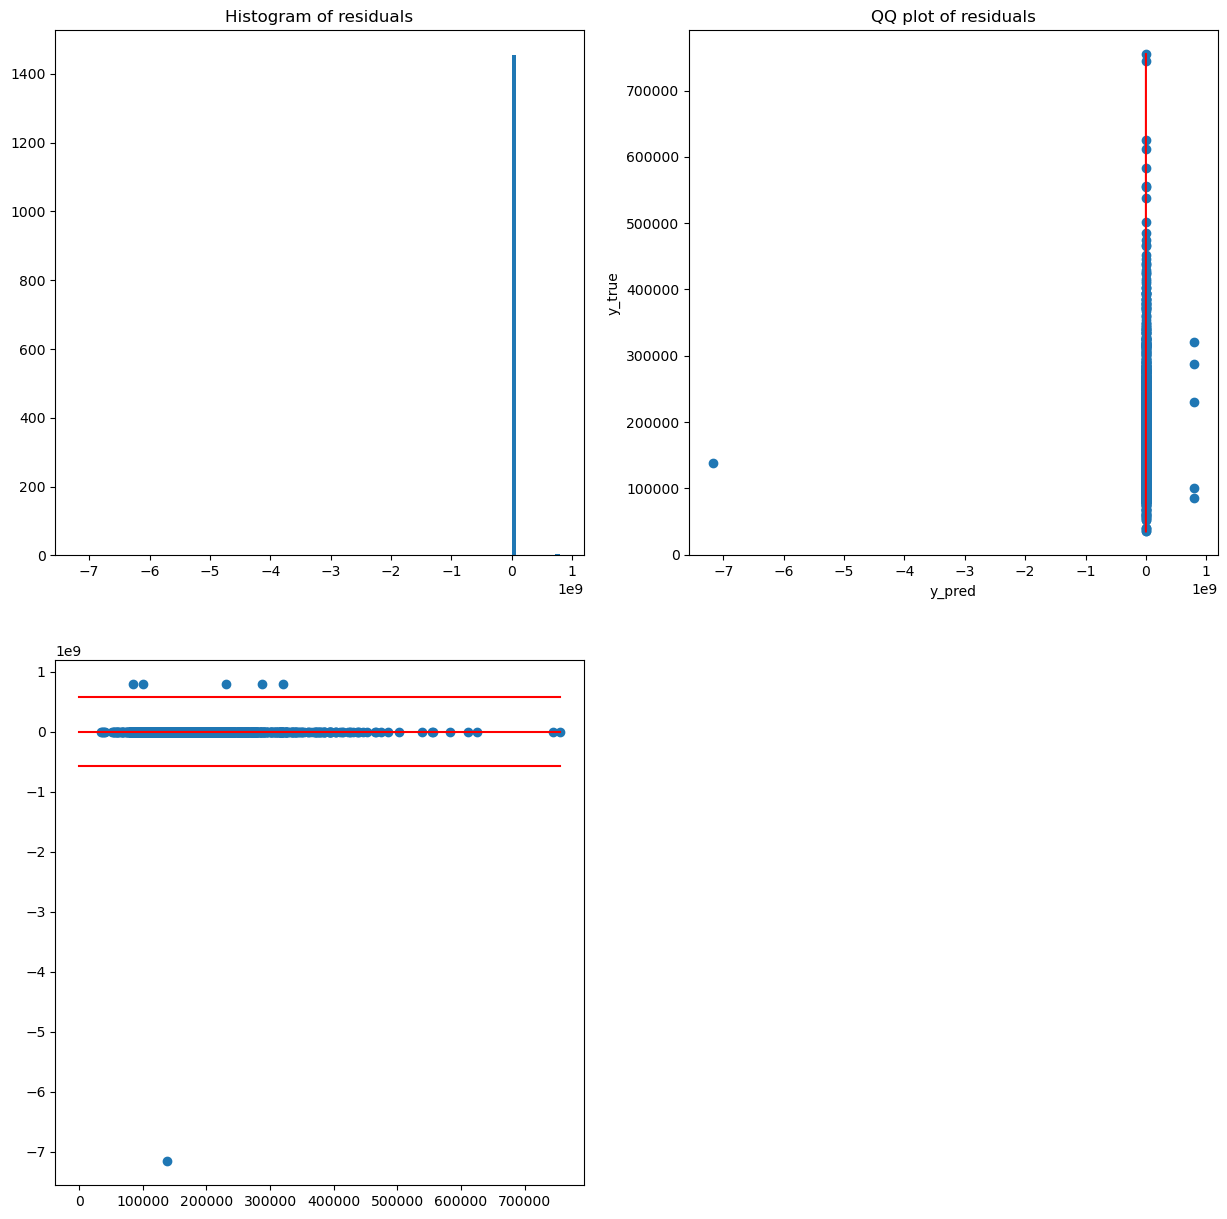

In [250]:
#Check normal distribution of Residuals
import matplotlib.pyplot as plt

def test_linreg(y_pred, y):
    residuals = y_pred - y

    fig = plt.figure(figsize=(15,15))
    #histogram
    ax1 = plt.subplot(2,2,1)
    ax1.hist(residuals, bins=100)
    ax1.set_title('Histogram of residuals')

    #qq plot
    ax2 = plt.subplot(2,2,2)
    ax2.scatter(y_pred,y)
    ax2.plot([min(y),max(y)],[min(y),max(y)], color='red')
    ax2.set_title('QQ plot of residuals')
    ax2.set_ylabel('y_true')
    ax2.set_xlabel('y_pred')

    #Heteroscedasity test
    ax3 = plt.subplot(2,2,3)
    ax3.scatter(y, residuals)
    ax3.plot([0,max(y)],[0,0], color='red')
    ax3.plot([0,max(y)],[-3*residuals.std(),-3*residuals.std()], color='red')
    ax3.plot([0,max(y)],[3*residuals.std(),3*residuals.std()], color='red')
    plt.show()
    
    return residuals
    
residuals = test_linreg(y_pred, y)

In [257]:
df[abs(residuals) > 2e6]

Norm  Feedr  PosN  Artery  RRAe  RRNn  RRAn  PosA  RRNe      Id  \
932    0.0    0.0   0.0     0.0   0.0   1.0   0.0   0.0   0.0   933.0   
1011   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1012.0   
1013   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1014.0   
1024   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1025.0   
1152   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1153.0   

      LotFrontage  LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
932          84.0  11670.0       1.0        0.0          9.0          5.0   
1011         75.0   9825.0       0.0        0.0          5.0          5.0   
1013         60.0   7200.0       0.0        0.0          5.0          4.0   
1024          0.0  15498.0       1.0        0.0          8.0          6.0   
1152         90.0  14115.0       1.0        0.0          6.0          7.0   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
932      2006.0        2006.0       302.0        5.0        3.0       5.0   
1011     1965.0        1965.0         0.0        3.0        3.0       0.0   
1013     1910.0        2006.0         0.0        3.0        3.0       3.0   
1024     1976.0        1976.0         0.0        4.0        3.0       4.0   
1152     1956.0        2004.0         0.0        3.0        3.0       3.0   

      BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
932        4.0           1.0         0.0         0.0     1905.0       1905.0   
1011       0.0           0.0         0.0         0.0        0.0          0.0   
1013       3.0           1.0       247.0       465.0      310.0       1022.0   
1024       3.0           3.0      1165.0       400.0        0.0       1565.0   
1152       3.0           1.0       296.0       547.0      230.0       1073.0   

      HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
932         5.0         1.0    1905.0       0.0           0.0     1905.0   
1011        3.0         0.0    1664.0       0.0           0.0     1664.0   
1013        3.0         0.0    1022.0       0.0           0.0     1022.0   
1024        3.0         1.0    2898.0       0.0           0.0     2898.0   
1152        5.0         1.0    1811.0       0.0           0.0     1811.0   

      BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
932            0.0           0.0       2.0       0.0           3.0   
1011           0.0           0.0       2.0       0.0           4.0   
1013           1.0           0.0       1.0       0.0           2.0   
1024           1.0           0.0       2.0       0.0           2.0   
1152           0.0           0.0       1.0       0.0           2.0   

      KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
932            1.0          5.0           8.0         0.0         1.0   
1011           2.0          3.0           8.0         0.0         0.0   
1013           1.0          3.0           4.0         5.0         0.0   
1024           1.0          4.0          10.0         0.0         1.0   
1152           1.0          5.0           6.0         0.0         1.0   

      FireplaceQu  GarageYrBlt  GarageCars  GarageArea  GarageQual  \
932           4.0       2006.0         3.0       788.0         3.0   
1011          0.0       1965.0         0.0         0.0         0.0   
1013          0.0       1956.0         1.0       280.0         3.0   
1024          4.0       1976.0         2.0       665.0         3.0   
1152          4.0       1956.0         2.0       470.0         3.0   

      GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
932          3.0         1.0         0.0        191.0            0.0   
1011         0.0         1.0         0.0          0.0            0.0   
1013         3.0         1.0         0.0         30.0          226.0   
1024         3.0         1.0         0.0         72.0          174.0   
1152         3.0         1.0         0.0          0.0         

In [259]:
# Remove outlier
df = df.drop([932,1011,1013,1024,1152])

# X and y creation
y = df['SalePrice']
X = df.drop('SalePrice',axis=1)

reg = LinearRegression()
y_pred = cross_val_predict(reg, X, y, cv=5)
mean_absolute_error(y_pred, y)

19803.286156047358

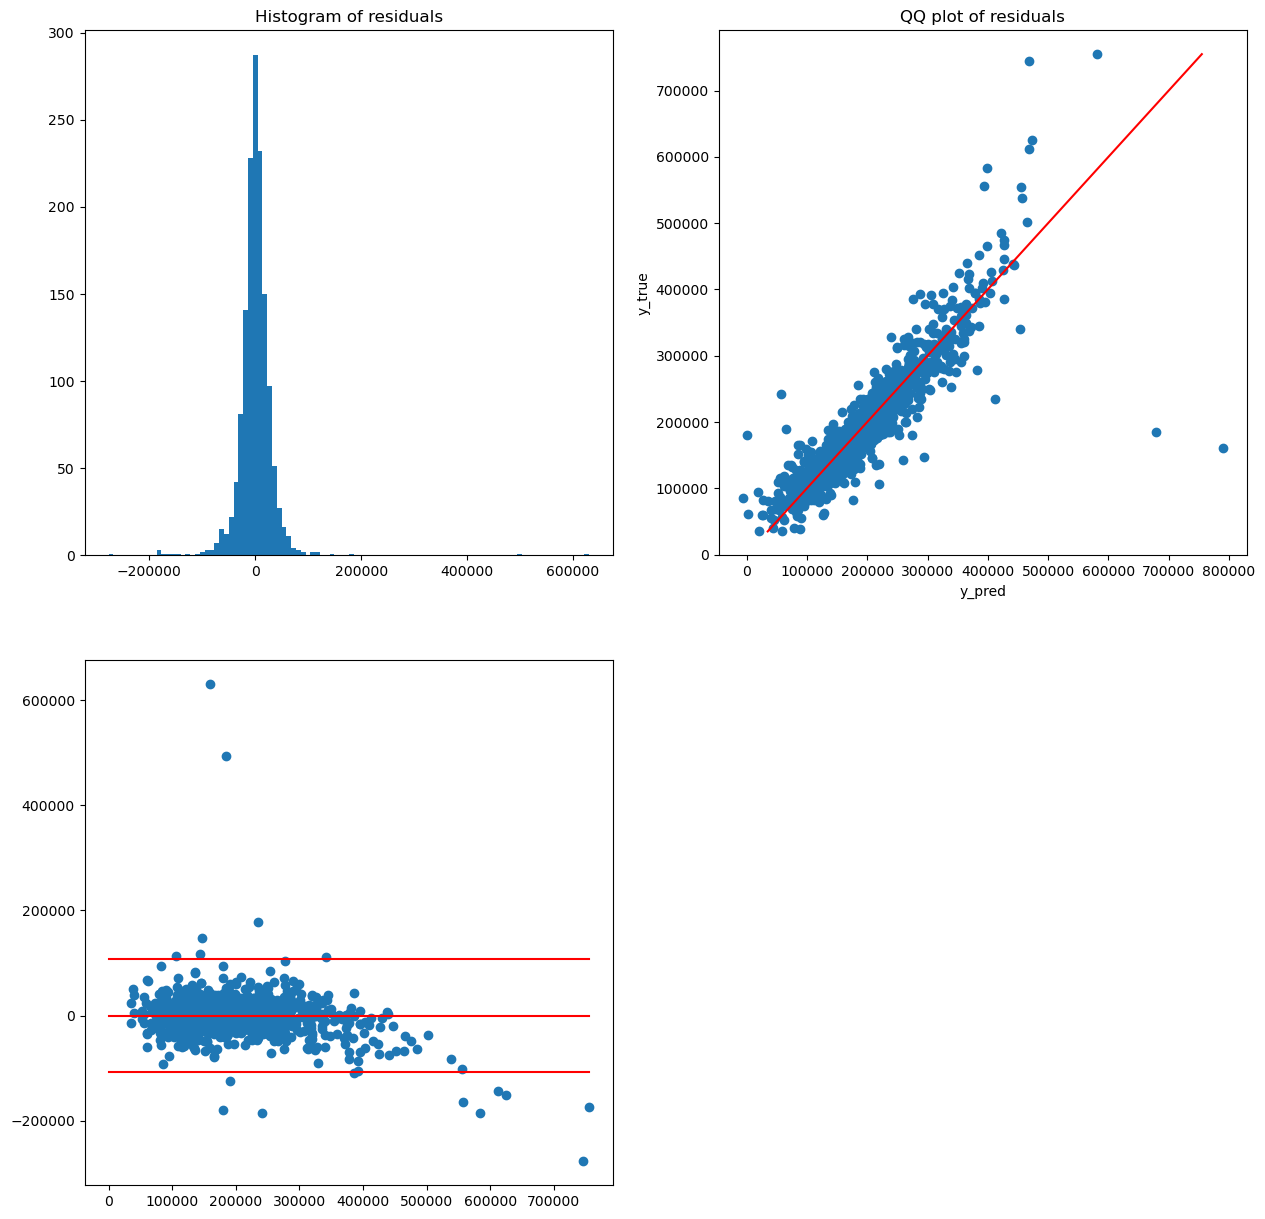

In [261]:
residuals = test_linreg(y_pred, y)

The residuals mostly follow a bell curve and the QQ plot appears to have a slope of 1. However, the residuals are skewed to the right, and there are several outliers. 

In [262]:
(residuals.quantile(0.975) - residuals.quantile(0.025))/residuals.std()

3.136178266572794

### Log the Target

Let's try training the Linear Regression with the log of the SalePrice, and exponentiate the output. Based on the results shown below, it looks like logging the SalePrice yields a lower mean absolute error and better conformity with the assumptions of linear regression.

In [263]:
reg = LinearRegression()
y_log = np.log(y)
y_pred = cross_val_predict(reg, X, y_log, cv=5)
mean_absolute_error(np.exp(y_pred), y)

17158.671336805088

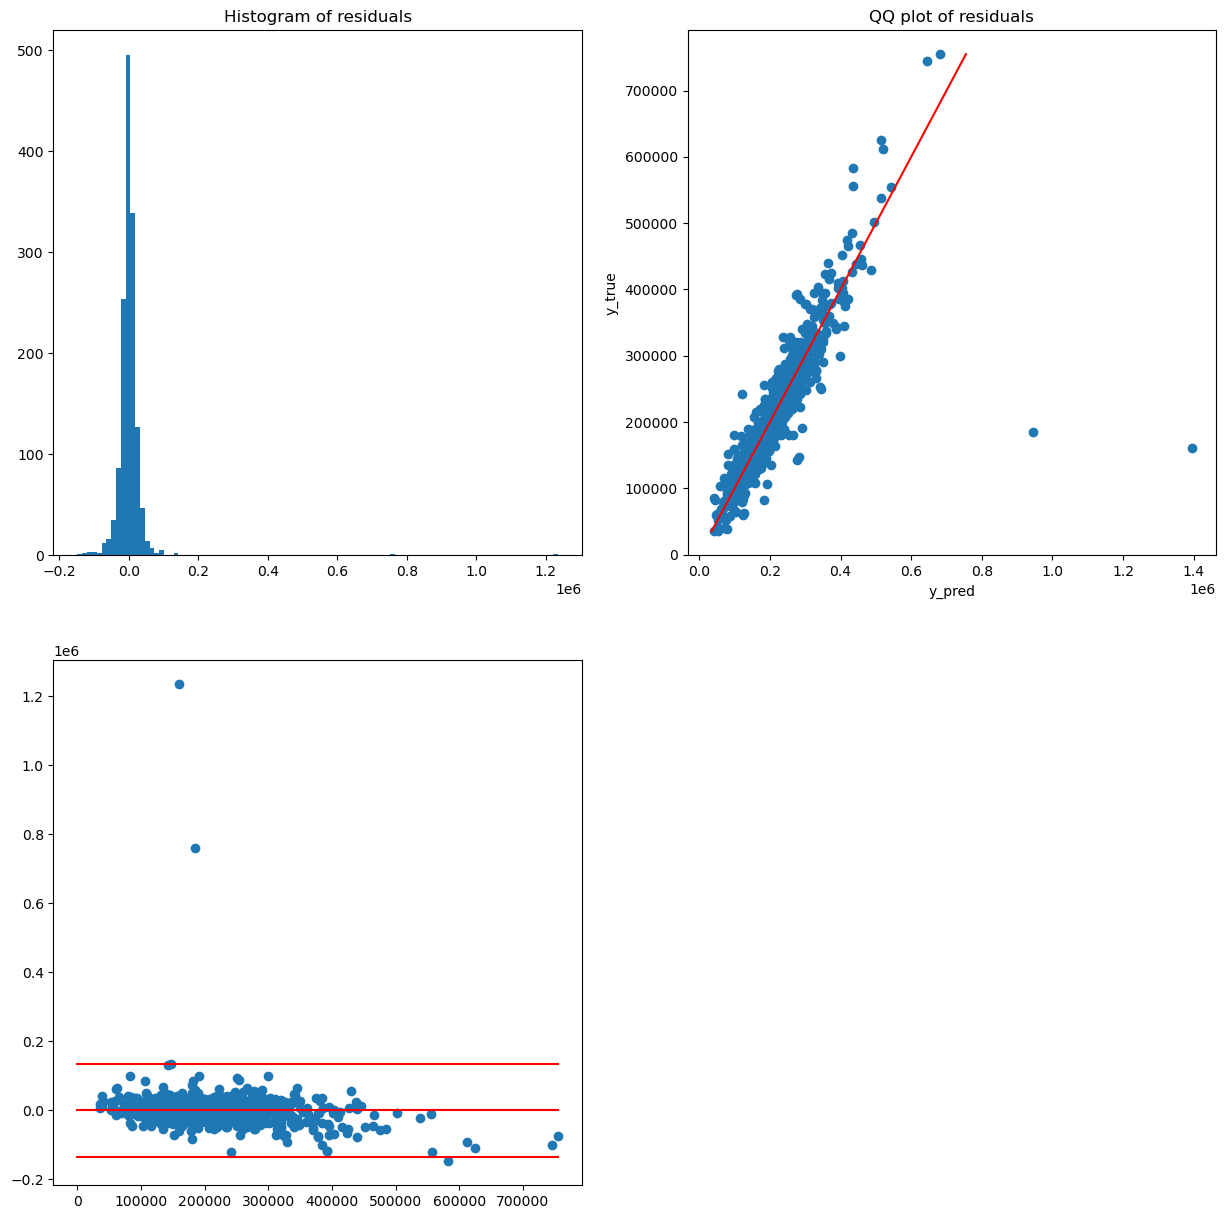

In [264]:
residuals = test_linreg(np.exp(y_pred), y)

In [265]:
(residuals.quantile(0.975) - residuals.quantile(0.025))/residuals.std()

2.132855634454874

There, however, does exist some outliers. Let's examine these.

In [266]:
#Check the outliers
pd.set_option('display.max_columns',1000)
df[residuals > 0.5e6]

Norm  Feedr  PosN  Artery  RRAe  RRNn  RRAn  PosA  RRNe      Id  \
523    0.0    0.0   2.0     0.0   0.0   0.0   0.0   0.0   0.0   524.0   
1298   0.0    1.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1299.0   

      LotFrontage  LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
523         130.0  40094.0       1.0        0.0         10.0          5.0   
1298        313.0  63887.0       3.0        0.0         10.0          5.0   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
523      2007.0        2008.0       762.0        5.0        3.0       5.0   
1298     2008.0        2008.0       796.0        5.0        3.0       5.0   

      BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
523        3.0           4.0      2260.0         0.0      878.0       3138.0   
1298       3.0           4.0      5644.0         0.0      466.0       6110.0   

      HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
523         5.0         1.0    3138.0    1538.0           0.0     4676.0   
1298        5.0         1.0    4692.0     950.0           0.0     5642.0   

      BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
523            1.0           0.0       3.0       1.0           3.0   
1298           2.0           0.0       2.0       1.0           3.0   

      KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
523            1.0          5.0          11.0         0.0         1.0   
1298           1.0          5.0          12.0         0.0         3.0   

      FireplaceQu  GarageYrBlt  GarageCars  GarageArea  GarageQual  \
523           4.0       2007.0         3.0       884.0         3.0   
1298          4.0       2008.0         2.0      1418.0         3.0   

      GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
523          3.0         1.0       208.0        406.0            0.0   
1298         3.0         1.0       214.0        292.0            0.0   

      3SsnPorch  ScreenPorch  PoolArea  PoolQC  MiscVal  SalePrice  HasGarage  \
523         0.0          0.0       0.0     0.0      0.0   184750.0        1.0   
1298        0.0          0.0     480.0     4.0      0.0   160000.0        1.0   

      DiffHouseGarageYrs  HasLowGarageDiff  Has2ndFlr  HasLowQualSF  \
523                  0.0               1.0        1.0           0.0   
1298                 0.0               1.0        1.0           0.0   

      HasVnrArea  NumBsmtFinType  Bsmt_ALQ_Area  Bsmt_BLQ_Area  Bsmt_GLQ_Area  \
523          0.0             2.0            0.0            0.0         2260.0   
1298         0.0             2.0            0.0            0.0         5644.0   

      Bsmt_LwQ_Area  Bsmt_Rec_Area  IsAvgGCond  IsAvgGQual   AvgRmSize  \
523             0.0            0.0         1.0         1.0  425.090909   
1298            0.0            0.0         1.0         1.0  470.166667   

      MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  \
523              0.0             0.0             0.0             0.0   
1298             0.0             0.0             0.0             0.0   

      MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
523              0.0            0.0            0.0            0.0   
1298             0.0            0.0            0.0            0.0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
523             0.0            0.0            1.0            0.0   
1298            0.0            0.0            1.0            0.0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
523             0.0            0.0            0.0            0.0   
1298            0.0            0.0            0.0            0.0   

      MSZoning_C (all)  MSZoning_FV  MSZoning_None  MSZoning_RH  MSZoning_RL  \
523                0.0          0.0            0.0          0.0          1.0   
1298               0.0          0.0            0.0          0.0          

Let's remove these outliers and then re-run the model

In [267]:
df = df.drop([523,1298],axis=0)

In [268]:
y = df['SalePrice']
X = pd.get_dummies(df.drop('SalePrice',axis=1))

reg = LinearRegression()
y_pred = cross_val_predict(reg, X, np.log(y), cv=5)
mean_absolute_error(np.exp(y_pred), y)

14956.247861265962

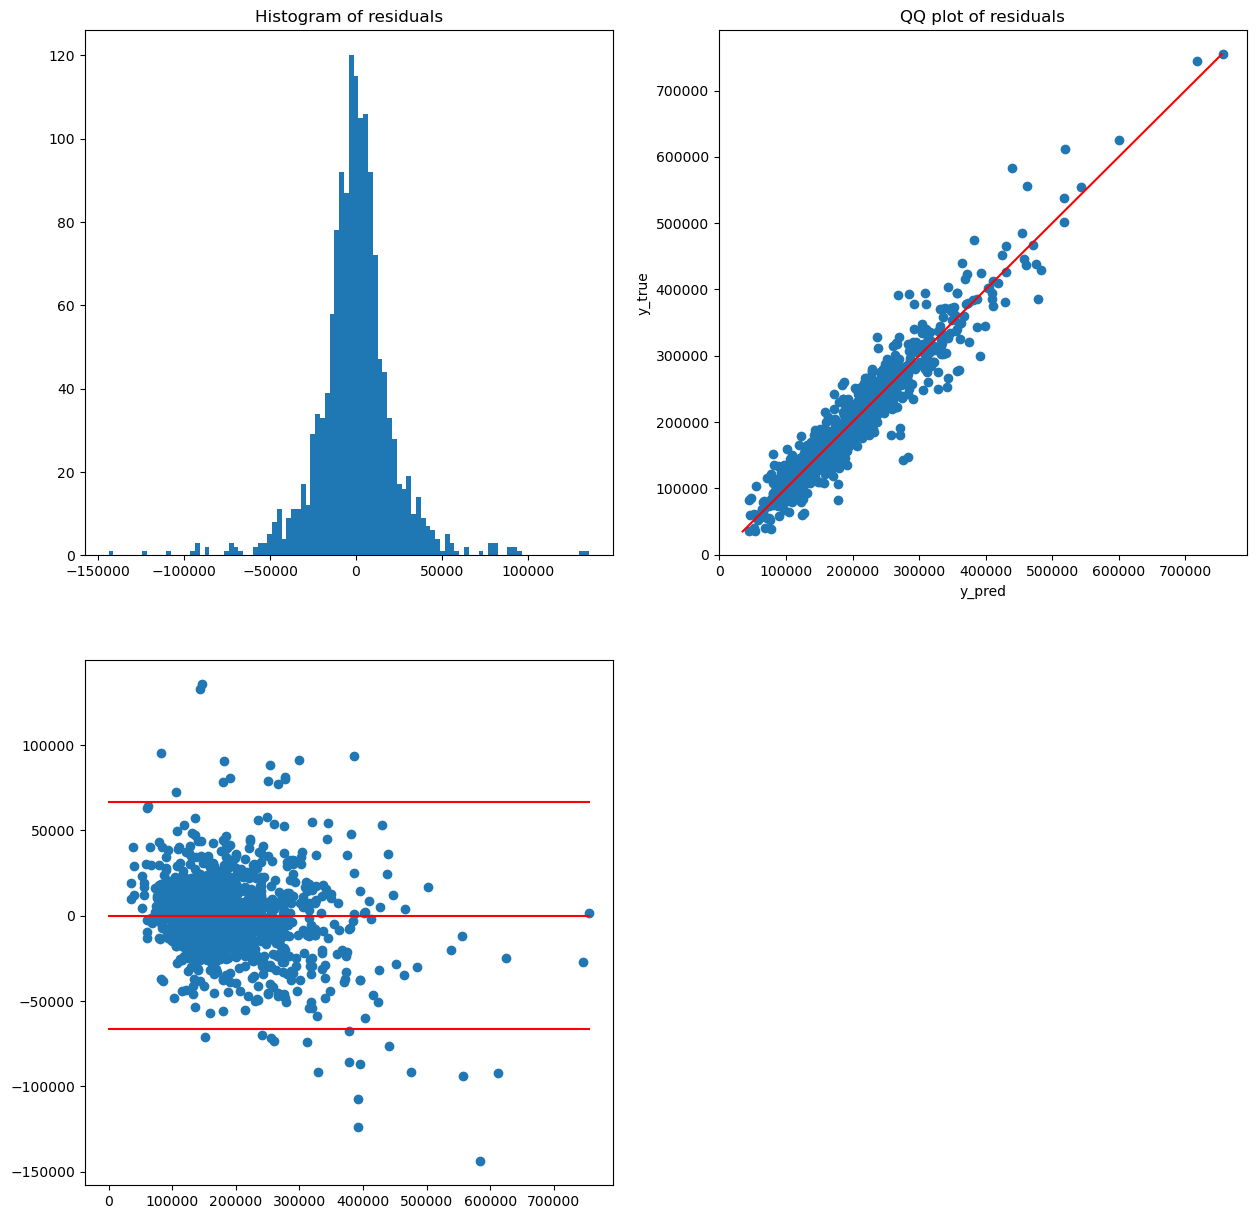

In [269]:
#Check normal distribution of Residuals
import matplotlib.pyplot as plt
residuals = test_linreg(np.exp(y_pred), y)

In [270]:
(residuals.quantile(0.975) - residuals.quantile(0.025))/residuals.std()

3.996023837593984

I'll save a csv file of the last version of the dataset, the one with the SalePrice variable logged and the outliers removed.

In [271]:
df_med = pd.concat([X,np.log(df['SalePrice'])],axis=1)
df_med.to_csv('./Interim Data/logged_outlier_removed.csv',index=False)

## Feature Selection and Regularization

Since there were a lot of redundant and insignificant features, let's see if removing some of those features would help us achieve more accurate results. Here we'll test the below feature selection methods:
- VIF
- Forward Selection
- Backward Selection

As well as some regularization methods:
- Ridge
- Lasso

In [272]:
#Reading in the Data
df_med = pd.read_csv('./Interim Data/logged_outlier_removed.csv').astype('float')

# X and y creation
y = df_med['SalePrice']
X = df_med.drop('SalePrice',axis=1)

### VIF

VIF is a filter feature selection method, which is when a subset of features are selected based on a certain criteria / value (in this case VIF) independent of the exact Machine Learning Algorithm the features will be used in.

VIF (Variance Inflation Factor) is a numerical measurement of a feature's multicollinearity with other features. A larger VIF means the the feature is more correlated with other features and should be dropped, and is a useful metric to filter out intercorrelated metrics, as we have here. As a rule of thumb, VIFs in the 5-20 range or higher are considered signs of multicollinearity and should be removed, though this threshold is arbitrary.

In [273]:
def vif_reduction(x, thresh = 5):
    output = x.copy()
    k = output.columns
    #Collection of vif and column names:
    vif = [(variance_inflation_factor(output.values,i), k[i]) for i in range(len(k))]
    for i, col in vif:
        if i > thresh:
            output = output.drop(col, axis=1)
    return output

for t in list(range(5,20,1)):
    vif_features = vif_reduction(X, thresh = t)
    reg = LinearRegression()
    y_pred = cross_val_predict(reg, vif_features, y, cv=5)
    mae = mean_absolute_error(np.exp(y_pred), np.exp(y))
    print('Threshold = {}, MAE = {}'.format(t,mae))

Threshold = 5, MAE = 25980.743408120135
Threshold = 6, MAE = 21691.40607072499
Threshold = 7, MAE = 21716.97024832561
Threshold = 8, MAE = 21530.456194434893
Threshold = 9, MAE = 20102.214298286515
Threshold = 10, MAE = 20102.214298286515
Threshold = 11, MAE = 20102.214298286515
Threshold = 12, MAE = 20102.214298286515
Threshold = 13, MAE = 20105.933470232678
Threshold = 14, MAE = 20211.998679748944
Threshold = 15, MAE = 20226.737754554593
Threshold = 16, MAE = 20226.737754554593
Threshold = 17, MAE = 20226.737754554593
Threshold = 18, MAE = 20226.737754554593
Threshold = 19, MAE = 20226.737754554593


It seems that the best VIF threshold for linear regression would be 9. Let's look at the columns.

In [274]:
vif_features = vif_reduction(X, thresh = 9)
vif_features.columns

Index(['PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe', 'Id',
       'LotFrontage', 'LotArea', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'HasLowGarageDiff', 'HasLowQualSF', 'IsAvgGCond', 'IsAvgGQual',
       'MSSubClass_150', 'MSZoning_None', 'Utilities_AllPub',
       'Utilities_NoSeWa', 'Utilities_None', 'RoofMatl_ClyTile',
       'SaleType_None', 'train_test_test', 'train_test_train',
       'ExMaterial_AsphShn', 'ExMaterial_CBlock+MetalSd',
       'ExMaterial_CBlock+Plywood', 'ExMaterial_CmentBd+AsbShng',
       'ExMaterial_HdBoard+St

In [275]:
len(vif_features.columns)

72

Though the final MAE is still higher than which we got using all the features, it is impressive that they are even on the same scale considering that we only retained approximately 1/5 of the features. 

I wonder if we could reduce it more by expanding the VIF threshold beyond 20.

In [276]:
for t in list(range(20,200,20)):
    vif_features = vif_reduction(X, thresh = t)
    reg = LinearRegression()
    y_pred = cross_val_predict(reg, vif_features, y, cv=5)
    mae = mean_absolute_error(np.exp(y_pred), np.exp(y))
    print('Threshold = {}, MAE = {}'.format(t,mae))

Threshold = 20, MAE = 20226.737754554593
Threshold = 40, MAE = 19392.46984466305
Threshold = 60, MAE = 19205.714570036893
Threshold = 80, MAE = 16435.640482262042
Threshold = 100, MAE = 16435.640482262042
Threshold = 120, MAE = 16435.640482262042
Threshold = 140, MAE = 16435.640482262042
Threshold = 160, MAE = 16435.640482262042
Threshold = 180, MAE = 16435.640482262042


In [277]:
vif_features = vif_reduction(X, thresh = 80)
len(vif_features.columns)

83

Looks like we could yield an even lower MAE by increasing the VIF threshold to 80, which would keep 83 out of the 328 original variables. Maybe I will use this reduced version of the dataset instead of the original even though the MAE is higher, considering that the difference isn't that drastic (approximately 12.5% less) and we can be victim to overfitting.

### Forward Selection

Both Forward and Backward Selections are wrapper feature selection methods, which means that features' importances are determined using the output of a certain Machine Learning algorithm. Based on the performance of the model with the selected filters variables are added or removed.

First, we are going to use Forward Selection, which is adding features, from an initial state of 0 features, to a model based on the scoring criteria. It stops when adding new features won't significantly improve the model.

In [46]:
feature_selections = []
reg = LinearRegression()

for i in tqdm(range(1,len(X.columns))):
    for_sel = SequentialFeatureSelector(reg,n_features_to_select=i,direction='forward',scoring='neg_mean_absolute_error')
    for_sel_features = for_sel.fit_transform(X,y)
    y_pred = cross_val_predict(reg, for_sel_features, y, cv=5)
    feature_selections.append(mean_absolute_error(np.exp(y_pred), np.exp(y)))
    
print(feature_selections.index(min(feature_selections))+1, min(feature_selections))

100%|█████████████████████████████████████| 279/279 [38:57:30<00:00, 502.69s/it]

78 12432.487841318138


In [50]:
#Let's try re-running this on another set of data

reg = LinearRegression()
sel = SequentialFeatureSelector(reg,n_features_to_select=78,direction='forward',scoring='neg_mean_absolute_error')
X2 = for_sel.fit_transform(X,y)
y_pred = cross_val_predict(reg, X2, y, cv=5)
mean_absolute_error(np.exp(y_pred), np.exp(y))

17609.476774186183

### Backward Elimination

In contrast to Forward Selection, Backward Elimination is removing features, from an initial state when all features are included, from a model based on their lack of significance and improvement in regards to the scoring criteria. 

It stops when removing features won't significantly improve the model.

In [278]:
X=X.drop('train_test_train',axis=1)

In [281]:
newX = pd.DataFrame(X.reset_index(drop=True))
feature_selections = []

for i in tqdm(range(len(newX.columns),1,-1)):
    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size = 0.3)
    #Fit model with i parameters
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    params = lm.coef_
    predictions = lm.predict(X_test)

    MSE = (sum((y_test-predictions)**2))/(len(newX)-len(newX.columns))
    
    var_b = newX.var()/((newX - newX.mean())**2).sum()
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b

    p_values =2*(1-stats.t.cdf(np.abs(ts_b),newX.shape[0]-1))

    myDF3 = pd.DataFrame({'Coefficients':params, 'Standard Errors': sd_b, 't values':ts_b, 'Probabilities':p_values})
    try:
        feature_selections.append((i, newX.columns, mean_absolute_error(np.exp(predictions),np.exp(y_test))))
    except ValueError:
        feature_selections.append((i, newX.columns, np.inf))
    try:
        newX = newX.drop(myDF3['Probabilities'].idxmax(),axis=1)
    except KeyError:
        break
        
print('The lowest MAE accomplished is {}, with {} parameters'.format(sorted(feature_selections, key=lambda x: x[2])[0][2], sorted(feature_selections, key=lambda x: x[2])[0][0]))

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 302/327 [00:04<00:00, 63.26it/s]

The lowest MAE accomplished is 13490.14460847235, with 302 parameters


In [291]:
reg = LinearRegression()
X2 = X[feature_selections[26][1]]
y_pred = cross_val_predict(reg, X2, y, cv=5)
mean_absolute_error(np.exp(y_pred), np.exp(y))

14905.310479672524

### Regularizations

Both Lasso and Ridge regressions are types of embedded feature selection methods. What this means is that the feature selection is part of the Machine Learning Algorithms.

Laso and Ridge regressions both regularization techniques that add a penalty term to the stadard Linear Regression to penalize large coefficients and to shrink (in Ridge Regression) and remove (Lasso Regression) variables that do not contribute to the model, hence the Feature Selection part of the Alforithms.

First, let's find the hyperparameters for the two regularized regression models. Others have said that normalizing / standardizing the data would work better for these models, so I'm going to be testing both the standardized and non-standardized version of the X values.

In [296]:
#Standarized X values
X_std = StandardScaler().fit_transform(X,y)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y, test_size = 0.3)

#Original X values
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size = 0.3)

#### Ridge Regression

First let's try the non-standardized version. I wrote a function to automate the hyperparameter tuning for the alpha to prevent having to manually adjust the range myself.

In [297]:
#Definind the Find Alpha Function

def alpha_find(model, is_std, min_value = 0.001,
        max_value = 0.01,
        max_round = 2,
        step = 0.001):
    #Keep expanding the range until told to stop.
    param_candidates = []
    while 1 == 1:
        alpha = np.arange(min_value, max_value, step)
        param_grid = {'alpha': alpha}

        model_cv = GridSearchCV(model,param_grid,cv=5)
        
        #If is_std = True, use the standardized dataset. Else use the original
        if is_std == True:
            X_train, y_train = X_train_std, y_train_std
        else:
            X_train, y_train = X_train_orig, y_train_orig
        model_cv.fit(X_train,y_train)

        best_alpha = model_cv.best_params_['alpha']
        
        #In case of borderline values, if best_alpha's been seen before then use that.
        if best_alpha in param_candidates:
            break
        else:
            param_candidates.append(best_alpha)
        
        #If best_param = max value, then expand range. If min value, reduce range. Else break.
        if (round(best_alpha, max_round) == max_value):
            min_value, max_value, step, max_round = min_value*10, max_value*10, step*10, max_round-1
        elif ((best_alpha) == min_value):
            min_value, max_value, step, max_round = min_value/10, max_value/10, step/10, max_round+1
        else:
            break
    print('Best Alpha for Model (Standarized = {}): '.format(is_std),model_cv.best_params_)    

In [300]:
#Define Ridge Model
rig = Ridge()

#Standarized
alpha_find(rig,True)

#Non-Standardized
alpha_find(rig,False)

Best Alpha for Model (Standarized = True):  {'alpha': 300.0}
Best Alpha for Model (Standarized = False):  {'alpha': 30.0}


With our hyperparameters, let's try fitting the model with the data and see what we get.

In [299]:
#Standardized
rig = Ridge(alpha=300)
y_pred = cross_val_predict(rig, X_std, y, cv=5)
print('Standardized Dataset: ', mean_absolute_error(np.exp(y_pred), np.exp(y)))

Standardized Dataset:  14039.421213247744


In [302]:
#Non-Standardized
rig = Ridge(alpha=30)
y_pred = cross_val_predict(rig, X, y, cv=5)
print('Original Dataset: ', mean_absolute_error(np.exp(y_pred), np.exp(y)))

Original Dataset:  13754.970513352688


Non-standardized was a little better, but both were lower than our previous lowest MAE (14914.91). Now let's try Lasso.

#### Lasso

Similar to Ridge, let's first find the appropriate hyperparameters for Lasso.

In [303]:
lasso = Lasso()

alpha_find(lasso, is_std=True)
alpha_find(lasso, is_std=False)

Best Alpha for Model (Standarized = True):  {'alpha': 0.004}
Best Alpha for Model (Standarized = False):  {'alpha': 0.001}


Now the we have the hyperparameters, let's run the model and see what we get.

In [304]:
#Standardized
las = Lasso(alpha=0.004)
y_pred = cross_val_predict(las, X_std, y, cv=5)
print('Standardized Dataset: ', mean_absolute_error(np.exp(y_pred), np.exp(y)))

Standardized Dataset:  13460.162486884337


In [305]:
#Original
las = Lasso(alpha=0.001)
y_pred = cross_val_predict(las, X, y, cv=5)
print('Non-Standardized Dataset: ', mean_absolute_error(np.exp(y_pred), np.exp(y)))

Non-Standardized Dataset:  13825.962285984957


The results were better than 14915.91 and were also better than Ridge. Looks like the standardized dataset yielded a bit of a better result for Lasso compared to Ridge. This makes sense, since we can see in the EDA + Cleaning Notebook that there were several Lasso is known to double as a feature selector, since it reduces the coefficients of insignificant variables to 0. Let's take a look at what variables were deemed important.

In [306]:
#Let's also look at what variables Lasso deemed most important.
lasso_coef = las.fit(X,y).coef_
len([coef for coef in lasso_coef if coef != 0])

87

In [307]:
var_coef = pd.DataFrame({'Variable':X.columns,'Coefficent':lasso_coef})
var_coef = var_coef[var_coef['Coefficent']!=0].sort_values('Coefficent')
var_coef

Variable  Coefficent
90        MSZoning_C (all)   -0.215494
95             MSZoning_RM   -0.059923
248  SaleCondition_Abnorml   -0.058108
42              Functional   -0.031516
76          MSSubClass_160   -0.028221
..                     ...         ...
15             OverallCond    0.040503
0                     Norm    0.040607
244           SaleType_New    0.041894
14             OverallQual    0.053780
119   Neighborhood_Crawfor    0.092800

[87 rows x 2 columns]

# RandomForest

The Random Forest regressor is an ensemble method, consisting of multiple Decision Trees fitted on a group of bagged data and a number of bagged features. Unlike the linear models it is not a parametric method and makes no assumption about the shape of the data, and thus might be better at predicting non-linear patterns. However, our data fits pretty well linearly, so this might not perform better.

First, let's see how well the Random Forest performs on the dataset without any hyperparametric tuning. We wouldn't need to do any feature reduction since it was "in-built" into the model via the feature importance feature.

In [308]:
#Logged
rf = RandomForestRegressor()
y_pred = cross_val_predict(rf, X, y, cv=5)
mean_absolute_error(np.exp(y_pred),np.exp(y))

17150.652435049193

Next, let's do some hyperparameter tuning. Generally, Random Forests are less sensitive than others to hyperparameters, but I'm going to tune the final hyperparameters nevertheless:
- n_estimators: Number of trees.
- max_depth: A parameter that controls tree depth. 
- max_features: The number of features to consider when looking for the best split; Two common examples are the square root of the total number of features and one third of the total number of features.

In [310]:
rf = RandomForestRegressor(criterion='absolute_error')
param_grid = {'n_estimators': range(50,500,50)
    ,'max_depth': [None, 10, 50, 100]
    ,'max_features': ['sqrt', 'log2', 0,3, None]}
model_cv = GridSearchCV(rf,param_grid,cv=5)
model_cv.fit(X_train_orig,np.exp(y_train_orig))
model_cv.best_params_

{'max_depth': None, 'max_features': None, 'n_estimators': 50}

Judging by how well this performed compared to the untuned model, however, I think the hyperparameter tuning wasn't very meaningful.

In [311]:
best_model = model_cv.best_estimator_
y_pred = best_model.predict(X_test_orig)
mean_absolute_error(y_pred,np.exp(y_test_orig))

17724.68422018349

# XGBoost

Next, we will try XGBoost (Extreme Gradient Boosting), which is also an ensemble method like RandomForest but also Gradient Boosted, which means that over each iteration the model would be modified to correct the erros of its previous function.

Below I will try the model with some random hyperparameters. Later on I will tune them.

In [312]:
# create an xgboost regression model
xg = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
y_pred = cross_val_predict(xg, X, y, cv=5)
print(mean_absolute_error(np.exp(y_pred), np.exp(y)))

14932.76382790978


In [313]:
xg = XGBRegressor()
param_grid = {'n_estimators': range(100,1000,100)
    ,'max_depth': [None, 10, 50, 100]
    ,'eta': [0.001,0.01,0.1,1.0]
    ,'subsample':[0.5,0.9,0.1]
    ,'colsample_bytree':[0.1,1.1,0.1]}
model_cv = GridSearchCV(xg,param_grid,cv=5)
model_cv.fit(X_train_orig,np.exp(y_train_orig))

print('Best Params: ', model_cv.best_params_)

y_pred = cross_val_predict(model_cv.best_estimator_, X, y, cv=5)
print('Resulting Mean Absolute Error: ', mean_absolute_error(np.exp(y_pred), np.exp(y)))

Best Params:  {'colsample_bytree': 0.1, 'eta': 0.01, 'max_depth': None, 'n_estimators': 900, 'subsample': 0.5}
Resulting Mean Absolute Error:  15145.471671616739


# Blending

In the Kernel, some users blended the results from multiple models and was able to obtain a better result. Looking below, it definitely was better than the Linear Regression, Random Forest, and XGBRegressor. However, the Lasso still came out a bit better.

In [319]:
#Blending all together

lin = LinearRegression()
lin_y_pred = cross_val_predict(lin, X, y, cv=5)

las = Lasso(alpha=0.003)
las_y_pred = cross_val_predict(las, X_std, y, cv=5)

rf = RandomForestRegressor()
rf_y_pred = cross_val_predict(rf, X, y, cv=5)

xg = XGBRegressor(max_depth=None, n_estimators=600, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg_y_pred = cross_val_predict(xg, X_std, y, cv=5)

final_y_pred = (lin_y_pred + las_y_pred + rf_y_pred + xg_y_pred)/4
print(mean_absolute_error(np.exp(final_y_pred), np.exp(y)))

13369.682046168307


# Final prediction

I will be predicting using the Lasso Regression, as it is the best.

In [315]:
#Loading testing csv
test = pd.read_csv('./Interim Data/cleaned_test.csv')
test.head()

index  Norm  Feedr  PosN  Artery  RRAe  RRNn  RRAn  PosA  RRNe      Id  \
0    0.0   0.0    1.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1461.0   
1    1.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1462.0   
2    2.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1463.0   
3    3.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1464.0   
4    4.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0  1465.0   

   LotFrontage  LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
0         80.0  11622.0       0.0        0.0          5.0          6.0   
1         81.0  14267.0       1.0        0.0          6.0          6.0   
2         74.0  13830.0       1.0        0.0          5.0          5.0   
3         78.0   9978.0       1.0        0.0          6.0          6.0   
4         43.0   5005.0       1.0        0.0          8.0          5.0   

   YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
0     1961.0        1961.0         0.0        3.0        3.0       3.0   
1     1958.0        1958.0       108.0        3.0        3.0       3.0   
2     1997.0        1998.0         0.0        3.0        3.0       4.0   
3     1998.0        1998.0        20.0        3.0        3.0       3.0   
4     1992.0        1992.0         0.0        4.0        3.0       4.0   

   BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0       3.0           1.0       468.0       144.0      270.0        882.0   
1       3.0           1.0       923.0         0.0      406.0       1329.0   
2       3.0           1.0       791.0         0.0      137.0        928.0   
3       3.0           1.0       602.0         0.0      324.0        926.0   
4       3.0           1.0       263.0         0.0     1017.0       1280.0   

   HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0        3.0         1.0     896.0       0.0           0.0      896.0   
1        3.0         1.0    1329.0       0.0           0.0     1329.0   
2        4.0         1.0     928.0     701.0           0.0     1629.0   
3        5.0         1.0     926.0     678.0           0.0     1604.0   
4        5.0         1.0    1280.0       0.0           0.0     1280.0   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           0.0           0.0       1.0       0.0           2.0           1.0   
1           0.0           0.0       1.0       1.0           3.0           1.0   
2           0.0           0.0       2.0       1.0           3.0           1.0   
3           0.0           0.0       2.0       1.0           3.0           1.0   
4           0.0           0.0       2.0       0.0           2.0           1.0   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  \
0          3.0           5.0         0.0         0.0          0.0   
1          4.0           6.0         0.0         0.0          0.0   
2          3.0           6.0         0.0         1.0          3.0   
3          4.0           7.0         0.0         1.0          4.0   
4          4.0           5.0         0.0         0.0          0.0   

   GarageYrBlt  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0       1961.0         1.0       730.0         3.0         3.0         1.0   
1       1958.0         1.0       312.0         3.0         3.0         1.0   
2       1997.0         2.0       482.0         3.0         3.0         1.0   
3       1998.0         2.0       470.0         3.0         3.0         1.0   
4       1992.0         2.0       506.0         3.0         3.0         1.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0       140.0          0.0            0.0        0.0        120.0       0.0   
1       393.0         36.0            0.0        0.0          0.0       0.0   
2       212.0         34.0            0.0        0.0          0.0       0.0   
3       360.0         36.0            0.0        0.0         

In [322]:
test = test.drop(['Id'],axis=1)
test = test.drop(['SalePrice'],axis=1)
test.head()

index  Norm  Feedr  PosN  Artery  RRAe  RRNn  RRAn  PosA  RRNe  \
0    0.0   0.0    1.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   
1    1.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   
2    2.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   
3    3.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   
4    4.0   1.0    0.0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   

   LotFrontage  LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
0         80.0  11622.0       0.0        0.0          5.0          6.0   
1         81.0  14267.0       1.0        0.0          6.0          6.0   
2         74.0  13830.0       1.0        0.0          5.0          5.0   
3         78.0   9978.0       1.0        0.0          6.0          6.0   
4         43.0   5005.0       1.0        0.0          8.0          5.0   

   YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
0     1961.0        1961.0         0.0        3.0        3.0       3.0   
1     1958.0        1958.0       108.0        3.0        3.0       3.0   
2     1997.0        1998.0         0.0        3.0        3.0       4.0   
3     1998.0        1998.0        20.0        3.0        3.0       3.0   
4     1992.0        1992.0         0.0        4.0        3.0       4.0   

   BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0       3.0           1.0       468.0       144.0      270.0        882.0   
1       3.0           1.0       923.0         0.0      406.0       1329.0   
2       3.0           1.0       791.0         0.0      137.0        928.0   
3       3.0           1.0       602.0         0.0      324.0        926.0   
4       3.0           1.0       263.0         0.0     1017.0       1280.0   

   HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0        3.0         1.0     896.0       0.0           0.0      896.0   
1        3.0         1.0    1329.0       0.0           0.0     1329.0   
2        4.0         1.0     928.0     701.0           0.0     1629.0   
3        5.0         1.0     926.0     678.0           0.0     1604.0   
4        5.0         1.0    1280.0       0.0           0.0     1280.0   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           0.0           0.0       1.0       0.0           2.0           1.0   
1           0.0           0.0       1.0       1.0           3.0           1.0   
2           0.0           0.0       2.0       1.0           3.0           1.0   
3           0.0           0.0       2.0       1.0           3.0           1.0   
4           0.0           0.0       2.0       0.0           2.0           1.0   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  \
0          3.0           5.0         0.0         0.0          0.0   
1          4.0           6.0         0.0         0.0          0.0   
2          3.0           6.0         0.0         1.0          3.0   
3          4.0           7.0         0.0         1.0          4.0   
4          4.0           5.0         0.0         0.0          0.0   

   GarageYrBlt  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0       1961.0         1.0       730.0         3.0         3.0         1.0   
1       1958.0         1.0       312.0         3.0         3.0         1.0   
2       1997.0         2.0       482.0         3.0         3.0         1.0   
3       1998.0         2.0       470.0         3.0         3.0         1.0   
4       1992.0         2.0       506.0         3.0         3.0         1.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0       140.0          0.0            0.0        0.0        120.0       0.0   
1       393.0         36.0            0.0        0.0          0.0       0.0   
2       212.0         34.0            0.0        0.0          0.0       0.0   
3       360.0         36.0            0.0        0.0          0.0       0.0   
4         0.0         82.0    

In [323]:
test_std = StandardScaler().fit_transform(test)

In [324]:
las = Lasso(alpha = 0.003)
las.fit(X_std,y)
preds = las.predict(test_std)

In [325]:
np.exp(preds)

array([123184.53369948, 157488.07223501, 181224.88893267, ...,
       164592.03870167, 122670.37410454, 230080.08391326])

In [326]:
pd.DataFrame(np.exp(preds)).to_csv('submissions.csv')